In [1]:
import sys
import cv2
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

%matplotlib inline

# extract_squares.py


In [2]:
class SquareDetector:
    """Class for detecting and processing squares in images."""

    THRESH = 10  # For edge detection
    AREA_THRESHOLD = 8000  # Minimum area to consider
    EXPECTED_COLS = 5
    EXPECTED_ROWS = 7
    EXPECTED_TOTAL = 35  # Expected number of icon squares

    @staticmethod
    def filter_by_aspect_ratio(
        squares: List[np.ndarray],
        max_ratio: float = 2.0
    ) -> List[np.ndarray]:
        """Filter out rectangles that are too long compared to their width."""
        filtered = []

        for sq in squares:
            _, _, w, h = cv2.boundingRect(sq)
            aspect_ratio = max(w, h) / min(w, h)
            if aspect_ratio <= max_ratio:
                filtered.append(sq)
        return filtered

    @staticmethod
    def find_squares(image: np.ndarray):
        """Find large blobs in the given image."""
        squares = []

        # Search for squares
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Canny edge detection
        gray = cv2.Canny(gray, 0, 0)
        gray = cv2.dilate(gray, None)

        # Find contours
        contours, _ = cv2.findContours(
            gray,
            cv2.RETR_LIST,
            cv2.CHAIN_APPROX_SIMPLE
            )

        # Testing each contour
        for contour in contours:
            # Skip small areas (noise)
            area = abs(cv2.contourArea(contour))
            if area < SquareDetector.AREA_THRESHOLD:
                continue

            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int32(box)

            squares.append(box)

        # Filter rectangles out
        squares = SquareDetector.filter_by_aspect_ratio(squares)
        return squares

    @staticmethod
    def row_map_by_area(
        squares: List[np.ndarray]
    ) -> Dict[int, List[Tuple]]:
        """Select 35 squares by area similarity, then group them into rows."""
        if len(squares) < SquareDetector.EXPECTED_TOTAL:
            raise ValueError(
                "Not enough squares: expected at least "
                + f"{SquareDetector.EXPECTED_TOTAL}, got {len(squares)}"
            )

        # Selecting 35 squares by area similarity
        rects = [(sq, cv2.boundingRect(sq)) for sq in squares]
        areas = np.array([w * h for _, (_, _, w, h) in rects])

        median_area = np.median(areas)
        diffs = np.abs(areas - median_area)

        selected_idx = np.argsort(diffs)[:SquareDetector.EXPECTED_TOTAL]
        selected_rects = [rects[i][1] for i in selected_idx]

        # Sort by y center (top to bottom)
        selected_rects.sort(key=lambda r: r[1] + r[3] / 2)

        # Make rows
        grid: Dict[int, List[Tuple]] = {}

        for row_idx in range(SquareDetector.EXPECTED_ROWS):
            start = row_idx * SquareDetector.EXPECTED_COLS
            end = start + SquareDetector.EXPECTED_COLS

            row = selected_rects[start:end]

            if len(row) != SquareDetector.EXPECTED_COLS:
                raise RuntimeError(
                    f"Row {row_idx} has {len(row)} squares" +
                    f"instead of {SquareDetector.EXPECTED_COLS}"
                )

            grid[row_idx] = row

        return grid

    @staticmethod
    def remove_duplicates(
            squares: List[np.ndarray],
            tolerance: int = 30
    ) -> List[np.ndarray]:
        """Remove overlapping or nearly identical squares."""
        keep = [True] * len(squares)

        for i, sq1 in enumerate(squares):
            if not keep[i]:
                continue

            x1, y1, w1, h1 = cv2.boundingRect(sq1)
            area1 = w1 * h1

            for j in range(i + 1, len(squares)):
                if not keep[j]:
                    continue

                x2, y2, w2, h2 = cv2.boundingRect(squares[j])
                area2 = w2 * h2

                # Check if squares are similar in position
                is_similar = (
                    abs(x1 - x2) < tolerance and
                    abs(y1 - y2) < tolerance and
                    abs((x1 + w1) - (x2 + w2)) < tolerance and
                    abs((y1 + h1) - (y2 + h2)) < tolerance
                )

                if is_similar:
                    # Keep the bigger one
                    if area1 > area2:
                        keep[j] = False
                    else:
                        keep[i] = False
                        break

        filtered = [sq for i, sq in enumerate(squares) if keep[i]]
        return filtered

# process.py

In [3]:
def process_square(
    cropped_square: np.ndarray,
    padding: int = 20,
) -> np.ndarray:
    """
    Detect the drawing within a cropped square, zoom to its bounding box,
    and return a binary image resized to the original dimensions.
    """
    height, width = cropped_square.shape[:2]

    gray = cv2.cvtColor(cropped_square, cv2.COLOR_BGR2GRAY)

    # Binarize for contour detection
    # OTSU is used to automatically determine threshold value
    _, binary = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
    )

    contours, _ = cv2.findContours(
        binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:
        return binary # Return potentially empty binary if no contours

    # Bounding box over contours
    points = np.vstack(contours)
    x_rect, y_rect, w, h = cv2.boundingRect(points)

    # Expand bounding box with padding
    x_start = max(0, x_rect - padding)
    y_start = max(0, y_rect - padding)
    x_end = min(width, x_rect + w + padding)
    y_end = min(height, y_rect + h + padding)

    # Crop and resize binary image
    icon = binary[y_start:y_end, x_start:x_end]
    
    if icon.size == 0:
        return binary

    icon_resized = cv2.resize(
                    icon,
                    (width, height),
                    interpolation=cv2.INTER_NEAREST
                )
    # Morphological dilatation + opening to clean noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    thickened = cv2.dilate(icon_resized, kernel, iterations=1)
    clean_icon = cv2.morphologyEx(thickened, cv2.MORPH_OPEN, kernel)

    # if too much is removed, return previous image
    if cv2.countNonZero(clean_icon) < 0.8 * cv2.countNonZero(icon_resized):
        return icon_resized

    return clean_icon

# label.py

In [4]:
def labelling(
    squares: Dict[int, List[Tuple]],
    file_terrminology: str
) -> Dict[str, List[Tuple]]:
    """Assign labels to grouped squares based on their Y-position order."""
    labels = []
    if file_terrminology == "00000":
        labels = [
            'Warning',
            'Bomb',
            'Car',
            'Casualty',
            'Electricity',
            'Fire',
            'Fire_brigade'
        ]
    elif file_terrminology == "00001":
        labels = [
            'Gas',
            'Injury',
            'Paramedics',
            'Person',
            'Police',
            'Road_block',
            'Flood'
        ]
    else:
        print("Error: Unknown file terrminology")
        return {}

    # Sort groups by Y-coordinate (top to bottom)
    sorted_grps = sorted(squares.items(), key=lambda item: item[0])

    # Map labels to rectangle groups
    labeled_squares = {}
    for i, (_, rectangles) in enumerate(sorted_grps):
        if i < len(labels):
            labeled_squares[labels[i]] = rectangles
        else:
            print(f"Warning: {len(sorted_grps)} groups, {len(labels)} labels")
            break

    return labeled_squares

# main.py

In [5]:
def extract_terminology(filename: str) -> str:
    """Extract terminology code from filename."""
    if filename.startswith("00000"):
        return "00000"
    elif filename.startswith("00001"):
        return "00001"
    else:
        return ""

def save_debug_squares_image(
    image,
    squares: list,
    output_path: Path,
    filename: str,
    case: str
):
    """Save an image with frames around detected squares."""
    debug_img = image.copy()

    for sq in squares:
        x, y, w, h = cv2.boundingRect(sq)
        cv2.rectangle(
            debug_img,
            (x, y),
            (x + w, y + h),
            (0, 255, 0),
            thickness=2
        )

    debug_path = output_path / case
    debug_path.mkdir(parents=True, exist_ok=True)
    debug_path = debug_path / f"debug_{filename}"
    cv2.imwrite(str(debug_path), debug_img)

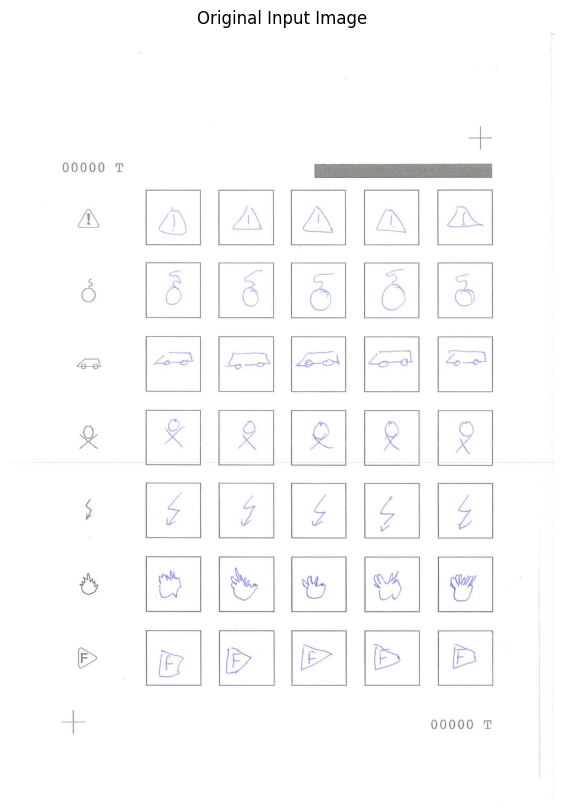

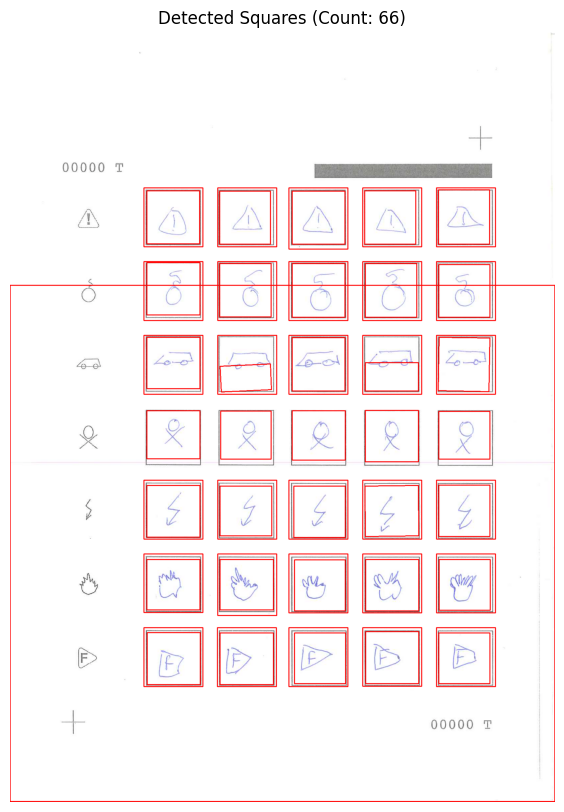

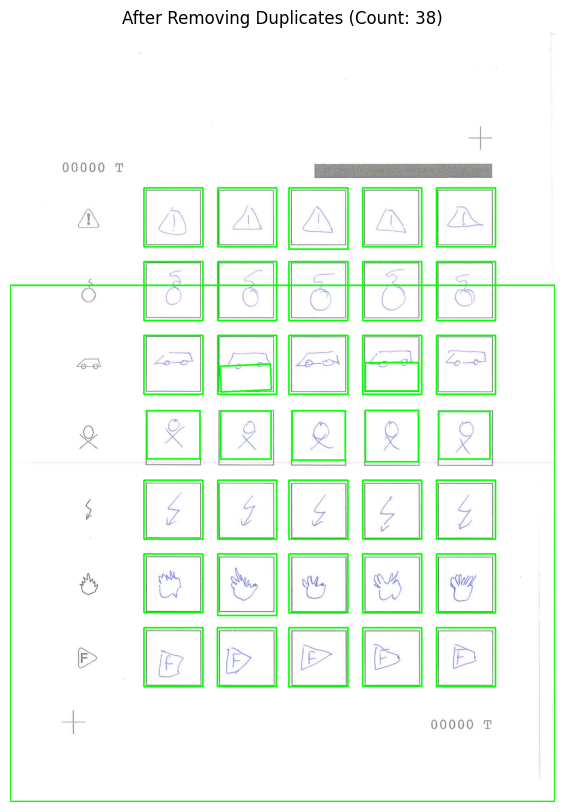

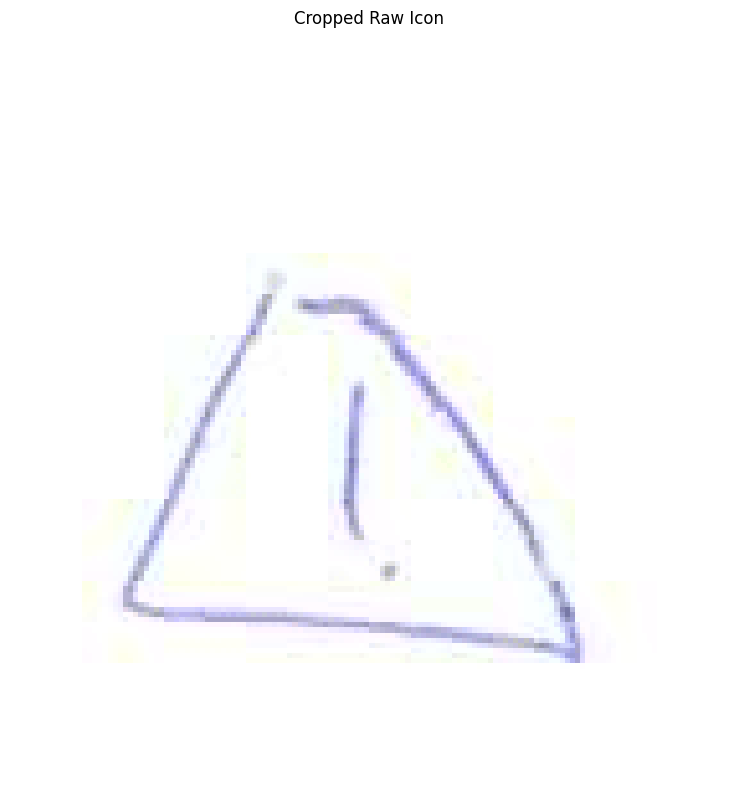

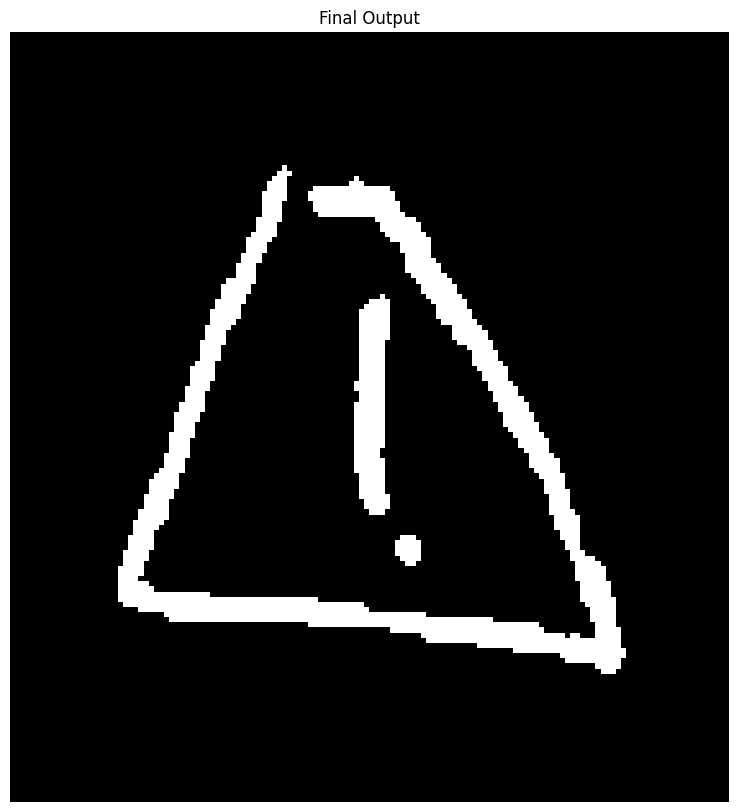

In [9]:
def visualize_step(title, image, is_bgr=True):
    plt.figure(figsize=(10, 10))
    if is_bgr:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Selecting a sample file 
sample_path = "../data/all/00000_1.png"
sample_img = cv2.imread(sample_path)

if sample_img is not None:
    
    # Show Original Image
    visualize_step("Original Input Image", sample_img)

    # Detect Squares
    raw_squares = SquareDetector.find_squares(sample_img)
    
    # Draw raw squares (Red)
    debug_img_1 = sample_img.copy()
    for sq in raw_squares:
        cv2.drawContours(debug_img_1, [sq], 0, (0, 0, 255), 2)
    visualize_step(f"Detected Squares (Count: {len(raw_squares)})", debug_img_1)

    # Remove Duplicates
    clean_squares = SquareDetector.remove_duplicates(raw_squares)
    
    # Draw clean squares (Green)
    debug_img_2 = sample_img.copy()
    for sq in clean_squares:
        cv2.drawContours(debug_img_2, [sq], 0, (0, 255, 0), 3)
    visualize_step(f"After Removing Duplicates (Count: {len(clean_squares)})", debug_img_2)

    # Group by Rows
    grouped = SquareDetector.row_map_by_area(clean_squares)
        
    # Process Single Icon Demo
    # Grab the first square of the first row
    first_rect = grouped[0][0]
    x, y, w, h = first_rect
    
    # Crop with margin
    y_start = max(0, y+15)
    y_end = min(sample_img.shape[0], y+h-15)
    x_start = max(0, x+20)
    x_end = min(sample_img.shape[1], x+w-20)
    cropped = sample_img[y_start:y_end, x_start:x_end]
    
    visualize_step("Cropped Raw Icon", cropped)
    
    # Binarization & Cleaning
    processed_icon = process_square(cropped)
    visualize_step("Final Output", processed_icon, is_bgr=False)


# Main Execution

In [7]:
def run_pipeline(source_directory_str: str, debug_mode: bool = False):
    source_path = Path(source_directory_str)
    extracted_path = source_path.parent / "extracted"
    extracted_path.mkdir(exist_ok=True)

    # Statistics
    total_processed = 0
    label_counters = {}  # Track counter for each label

    # Process all PNG files in the source directory
    png_files = sorted(list(source_path.glob("*.png")))

    if not png_files:
        print(f"No PNG files found in {source_path}")
        return

    for file_path in png_files:
        filename = file_path.name
        print(f"Processing: {filename}")

        # Extract terminology from filename
        terminology = extract_terminology(filename)
        if not terminology:
            print(f"Rejected {filename} - filename must start with '00000' or '00001'")
            continue

        # Read image
        img = cv2.imread(str(file_path))
        if img is None:
            print(f"Failed to read image: {file_path}")
            continue

        # Detect all squares and filter by aspect ratio
        squares = SquareDetector.find_squares(img)

        if debug_mode:
            print(f"Detected {len(squares)} squares")
            save_debug_squares_image(
                img, squares, extracted_path, filename, "detection"
            )

        # Remove duplicates
        squares = SquareDetector.remove_duplicates(squares)
        if debug_mode:
            print(f"{len(squares)} squares after removing duplicates")
            save_debug_squares_image(
                img, squares, extracted_path, filename, "duplicates"
            )

        # Map squares to groups by Y-coordinate
        try:
            grouped_squares = SquareDetector.row_map_by_area(squares)
        except ValueError as e:
            print(f"Skipping {filename}: {e}")
            continue
        except RuntimeError as e:
            print(f"Skipping {filename}: {e}")
            continue

        # Assign labels to groups
        labeled_squares = labelling(grouped_squares, terminology)

        if not labeled_squares:
            print("Failed to assign labels")
            continue

        # Process each labeled group
        squares_extracted = 0
        for label, rectangles in labeled_squares.items():
            # Create label folder if it doesn't exist
            label_folder = extracted_path / label
            label_folder.mkdir(exist_ok=True)

            # Initialize counter for this label if needed
            if label not in label_counters:
                label_counters[label] = 0

            # Save each square in the group
            for rect in rectangles:
                x, y, w, h = rect
                # Crop with pixel margin to avoid borders
                # Ensure we don't crop out of bounds
                y_start = max(0, y+15)
                y_end = min(img.shape[0], y+h-15)
                x_start = max(0, x+20)
                x_end = min(img.shape[1], x+w-20)
                
                cropped_square = img[y_start:y_end, x_start:x_end]
                
                if cropped_square.size == 0:
                    continue
                    
                processed_square = process_square(cropped_square)

                if cv2.countNonZero(processed_square) <= 600:
                    # Skip empty images
                    continue


                # Generate filename with source id and counter
                source_id = file_path.stem
                counter = label_counters[label]
                image_filename = f"{label}_{source_id}_{counter}.png"
                image_path = label_folder / image_filename

                cv2.imwrite(str(image_path), processed_square)

                label_counters[label] += 1
                squares_extracted += 1

        total_processed += 1
        print(f"Extracted {squares_extracted} squares")

    # Print summary
    print("\n" + "="*60)
    print("PROCESSING COMPLETE!")
    print("="*60)
    print(f"Total files processed: {total_processed}")
    print("\nSquares extracted by label:")
    for label, count in sorted(label_counters.items()):
        print(f"  {label:20s}: {count:5d} squares")

    print(f"\nResults saved to: {extracted_path}")

# Execution

In [8]:
SOURCE_DIRECTORY = "../data/all"

DEBUG_MODE = True

src_path = Path(SOURCE_DIRECTORY)

if src_path.exists():
    print(f"Target directory has been found: {src_path.resolve()}")
    run_pipeline(str(src_path), DEBUG_MODE)

else:
    print(f"Couldn't find the directory: {src_path.resolve()}")

Target directory has been found: C:\Users\PC1\OneDrive\Desktop\ders\deeplearning\project\code\Emergency-Icon-Classification-using-Deep-Learning\data\all
Processing: 00000_1.png
Detected 66 squares
38 squares after removing duplicates
Extracted 35 squares
Processing: 00000_10.png
Detected 74 squares
38 squares after removing duplicates
Extracted 35 squares
Processing: 00000_11.png
Detected 66 squares
36 squares after removing duplicates
Extracted 35 squares
Processing: 00000_12.png
Detected 66 squares
36 squares after removing duplicates
Extracted 35 squares
Processing: 00000_13.png
Detected 66 squares
36 squares after removing duplicates
Extracted 35 squares
Processing: 00000_14.png
Detected 66 squares
36 squares after removing duplicates
Extracted 35 squares
Processing: 00000_15.png
Detected 71 squares
35 squares after removing duplicates
Extracted 35 squares
Processing: 00000_16.png
Detected 70 squares
35 squares after removing duplicates
Extracted 35 squares
Processing: 00000_17.png